In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

from model import KeywordSpottingModel
from data_loader import load_speech_commands_dataset, TFDatasetAdapter
from utils import set_memory_GB,print_model_size, log_to_file, plot_learning_curves
from augmentations import apply_augmentations
from train import trainig_loop






/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/selective_scan_interface.py:164: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/selective_scan_interface.py:240: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout):
/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/triton/layer_norm.py:986: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/triton/layer_norm.py:1045: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type=

In [2]:
torch.cuda.is_available()

True

In [3]:
set_memory_GB(1)

Memory fraction set to 0.022458079576498518
Memory fraction in GB: 1.0


In [4]:
train_ds, val_ds, test_ds, info = load_speech_commands_dataset()

2024-08-25 09:33:43.467167: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-25 09:33:43.473062: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 09:33:43.485943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 09:33:43.506633: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 09:33:43.512719: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attemptin

In [5]:
# maintain seed for repructablity
np.seed = 42
# tf.random.set_seed(42)
torch.manual_seed(0)

In [6]:
label_names = info.features['label'].names
print(label_names)

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']


In [7]:
augmentations = [
    lambda x: apply_augmentations(x),
]

In [19]:
# Convert the TFDS dataset to a PyTorch Dataset
fixed_length = 16000
n_mfcc = 13
n_fft = 400
hop_length = 160
n_mels = 40
pytorch_train_dataset = TFDatasetAdapter(train_ds, fixed_length, n_mfcc, n_fft, hop_length, n_mels, augmentations)
pytorch_val_dataset = TFDatasetAdapter(val_ds, fixed_length, n_mfcc, n_fft, hop_length, n_mels, augmentations=None)

2024-08-25 12:13:48.301178: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
# Create a DataLoader to feed the data into the model
batch_size = 32
train_loader = DataLoader(pytorch_train_dataset, batch_size=batch_size, shuffle=True,num_workers=4,prefetch_factor=2)
val_loader = DataLoader(pytorch_val_dataset, batch_size=batch_size, shuffle=False,num_workers=4,prefetch_factor=2)

In [10]:
for audio, label in train_loader:
    print(audio.shape, label.shape)
    break


torch.Size([32, 13, 101]) torch.Size([32])


# Compute model size

In [20]:
# Initialize model, loss function, and optimizer
input_dim = 13  # Number of MFCC features
d_model = 101  # Number of frames
d_state = 32
d_conv = 20
expand = 2

model = KeywordSpottingModel(input_dim=input_dim, d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand, label_names=info.features['label'].names).to("cuda")


In [12]:

# # Register custom operation
inputs = torch.randn(batch_size, 13, 101).to("cuda")
        
# macs, params, ret_layer_info = thop.profile(model, inputs=(torch.randn(batch_size, 13, 101).to("cuda"),)
# ,custom_ops={Mamba: calculate_MAMBA_flops},report_missing=True, ret_layer_info=True)
# print()
# print(f"MACs: {macs} Which are {macs/1e9} Giga-MACs, Params: {params}")

print_model_size(model,input_size=inputs)

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.SiLU'>. Treat it as zero Macs and zero Params.
[INFO] Customize rule calculate_MAMBA_flops() <class 'mamba_ssm.modules.mamba_simple.Mamba'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[WARN] Cannot find rule for <class 'model.KeywordSpottingModel'>. Treat it as zero Macs and zero Params.

MACs: 583333176.0 Which are 0.583333176 Giga-MACs, Params: 179186.0

Layer-wise information:
Layer: proj
Total FLOPs: 4243616.0, Total Params: 1414.0

Layer: mamba_layers
Total FLOPs: 576439320.0, Total Params: 176144.0

Layer: batch_norms
Total FLOPs: 2

In [22]:

def calculate_total_macs(B, d_model, d_conv, d_state):
    # Defualt dt_rank calculation
    dt_rank = int(d_model / 16)
    # Defualt d_inner calculation
    d_inner = int(expand * d_model)
    # Input Projection
    macs_input_projection = B * (d_model * 2 * d_inner)
    
    # Convolution
    macs_convolution = B * (d_conv * d_inner)
    
    # SSM Projections
    macs_ssm_projections = B * ((d_inner * dt_rank + dt_rank * d_inner) + (2 * d_inner * d_state))
    
    # Discretization
    macs_discretization = B * (2 * d_inner * d_state)
    
    # State Update
    macs_state_update = B * ((d_inner * d_state + d_state * d_inner) + (d_state * d_inner + d_inner))
    
    # Output
    macs_output = B * (d_inner + d_inner * d_model)
    
    # Total MACs
    total_macs = (macs_input_projection + macs_convolution + macs_ssm_projections + 
                  macs_discretization + macs_state_update + macs_output)
    
    return total_macs

macs = calculate_total_macs(batch_size, d_model, d_conv, d_state)
print(f"Total MACs: {macs}")


Total MACs: 3626304


In [25]:
def calculate_training_macs(B, L, d_model, d_conv, d_state):

    # Defualt dt_rank calculation
    dt_rank = int(d_model / 16)
    # Defualt d_inner calculation
    d_inner = int(expand * d_model)
    
    # Input Projection
    macs_input_projection = B * L * d_model * (2 * d_model)
    
    # Convolutional Operation
    macs_convolution = B * L * d_model * d_conv
    
    # SSM Projections and Other Linear Operations
    macs_dt = B * L * d_model * dt_rank
    macs_BC = 2 * (B * L * d_model * d_state)
    macs_A = B * L * d_inner * d_state
    
    # Selective Scan Function (State Update)
    macs_state_update = B * L * d_inner * d_state
    
    # Output Projection
    macs_output_projection = B * L * d_inner * d_model
    
    # Total MACs
    total_macs = (macs_input_projection + macs_convolution + macs_dt + 
                  macs_BC + macs_A + macs_state_update + macs_output_projection)
    
    return total_macs

macs = calculate_training_macs(batch_size, input_dim, d_model, d_conv, d_state)
print(f"Total MACs: {macs/1e9} Giga-MACs")

Total MACs: 0.026133952 Giga-MACs


# Training loop

# With L2 regulariztion AND Droput layer

In [13]:
criterion = nn.CrossEntropyLoss()
base_optimizer = optim.Adam(model.parameters(), lr=0.0024, weight_decay=2.8e-05) # weight_decay for L2 regulariztopn

from torch_optimizer import Lookahead

optimizer = Lookahead(base_optimizer, k=5, alpha=0.5)  # Wrap around Adam


In [14]:
import torch.optim as optim
# Adding learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [15]:
num_epochs = 100
train_accuracies, val_accuracies, train_losses, val_losses = trainig_loop(model, num_epochs, train_loader, val_loader, criterion, optimizer, scheduler)

  0%|                                                                             | 0/2673 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:58<00:00, 15.01it/s]

Epoch 1/100, Training Loss: 0.9265328061868312, Training Accuracy: 72.91810410356562%


Validation Loss: 0.5788339977683146, Validation Accuracy: 82.15204909918828%
Learning rate after epoch 1: [0.0024]
Best model saved


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:39<00:00, 16.71it/s]

Epoch 2/100, Training Loss: 0.5101837167802751, Training Accuracy: 83.41499923986387%


Validation Loss: 0.41599110495063324, Validation Accuracy: 86.55711740249455%
Learning rate after epoch 2: [0.0024]
Best model saved


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:33<00:00, 17.47it/s]

Epoch 3/100, Training Loss: 0.43748043347923576, Training Accuracy: 85.75855737858288%


Validation Loss: 0.38914395948942704, Validation Accuracy: 87.32924173431003%
Learning rate after epoch 3: [0.0024]
Best model saved


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:34<00:00, 17.28it/s]

Epoch 4/100, Training Loss: 0.4011334815622491, Training Accuracy: 87.01570558173802%


Validation Loss: 0.35288197563701795, Validation Accuracy: 88.69530785982974%
Learning rate after epoch 4: [0.0024]
Best model saved


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:31<00:00, 17.67it/s]

Epoch 5/100, Training Loss: 0.3730695141953919, Training Accuracy: 87.96879933575798%


Validation Loss: 0.35019350418514467, Validation Accuracy: 89.35854286279944%
Learning rate after epoch 5: [0.0024]
Best model saved


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:29<00:00, 17.90it/s]

Epoch 6/100, Training Loss: 0.34742746925001683, Training Accuracy: 88.83886283636024%


Validation Loss: 0.35325884569106225, Validation Accuracy: 89.66541278954662%
Learning rate after epoch 6: [0.0024]
Best model saved


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:32<00:00, 17.47it/s]

Epoch 7/100, Training Loss: 0.33196035117256567, Training Accuracy: 89.31716387365368%


Validation Loss: 0.3179506208228914, Validation Accuracy: 90.32864779251634%
Learning rate after epoch 7: [0.0024]
Best model saved


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:35<00:00, 17.22it/s]

Epoch 8/100, Training Loss: 0.3165680263142683, Training Accuracy: 89.7650594660336%


Validation Loss: 0.3281950698693908, Validation Accuracy: 90.78400316768956%
Learning rate after epoch 8: [0.0024]
Best model saved


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:35<00:00, 17.16it/s]

Epoch 9/100, Training Loss: 0.3049860990007317, Training Accuracy: 90.16266913028733%


Validation Loss: 0.2986994227040795, Validation Accuracy: 91.27895466244308%
Learning rate after epoch 9: [0.0024]
Best model saved


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:33<00:00, 17.36it/s]

Epoch 10/100, Training Loss: 0.29588001559663035, Training Accuracy: 90.44216533545392%


Validation Loss: 0.2915136257563777, Validation Accuracy: 91.13046921401703%
Learning rate after epoch 10: [0.0024]


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:38<00:00, 16.91it/s]

Epoch 11/100, Training Loss: 0.2856501457265732, Training Accuracy: 90.7789641098806%


Validation Loss: 0.3096131380541321, Validation Accuracy: 91.48683429023956%
Learning rate after epoch 11: [0.0024]
Best model saved


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:31<00:00, 17.59it/s]

Epoch 12/100, Training Loss: 0.2812345430841673, Training Accuracy: 90.91344973161348%


Validation Loss: 0.32873679152277263, Validation Accuracy: 91.72441100772124%
Learning rate after epoch 12: [0.0024]
Best model saved


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:26<00:00, 18.20it/s]

Epoch 13/100, Training Loss: 0.28031426101778045, Training Accuracy: 90.94970237747191%


Validation Loss: 0.28931629516868085, Validation Accuracy: 91.88279548604237%
Learning rate after epoch 13: [0.0024]
Best model saved


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:25<00:00, 18.37it/s]

Epoch 14/100, Training Loss: 0.2710647642831264, Training Accuracy: 91.21282641999275%


Validation Loss: 0.3004097451715247, Validation Accuracy: 91.5363294397149%
Learning rate after epoch 14: [0.0024]


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:29<00:00, 17.83it/s]

Epoch 15/100, Training Loss: 0.27212652988979935, Training Accuracy: 91.26077346774099%


Validation Loss: 0.261745553404753, Validation Accuracy: 92.11047317362899%
Learning rate after epoch 15: [0.0024]
Best model saved


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:28<00:00, 18.01it/s]

Epoch 16/100, Training Loss: 0.2669503907200954, Training Accuracy: 91.40344517079674%


Validation Loss: 0.30469112550910515, Validation Accuracy: 91.85309839635715%
Learning rate after epoch 16: [0.0024]


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:27<00:00, 18.11it/s]

Epoch 17/100, Training Loss: 0.26283193554407286, Training Accuracy: 91.50050870648221%


Validation Loss: 0.2850427655090543, Validation Accuracy: 92.42724213027124%
Learning rate after epoch 17: [0.0024]
Best model saved


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:32<00:00, 17.54it/s]

Epoch 18/100, Training Loss: 0.26120003887716636, Training Accuracy: 91.65838313199471%


Validation Loss: 0.32073206288881506, Validation Accuracy: 92.34804989111068%
Learning rate after epoch 18: [0.0024]


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:30<00:00, 17.74it/s]

Epoch 19/100, Training Loss: 0.2543171698243552, Training Accuracy: 91.79637707429454%


Validation Loss: 0.37927389267501954, Validation Accuracy: 91.9025935458325%
Learning rate after epoch 19: [0.00023999999999999998]


100%|██████████████████████████████████████████████████████████████████| 2673/2673 [02:28<00:00, 17.94it/s]

Epoch 20/100, Training Loss: 0.22915914224365255, Training Accuracy: 92.64539065149513%


Validation Loss: 0.26101408876136795, Validation Accuracy: 93.25876064145714%
Learning rate after epoch 20: [0.00023999999999999998]
Early stopping triggered
Stopping training at epoch 20 due to early stopping


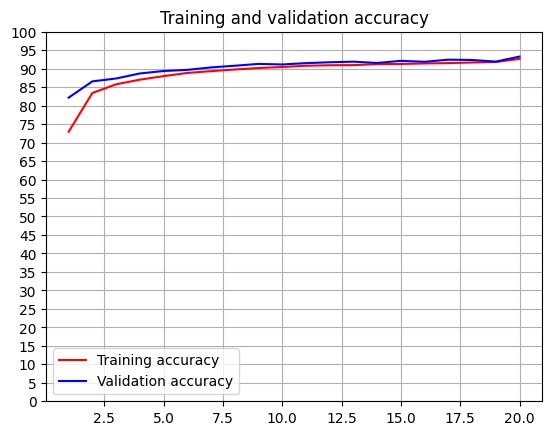

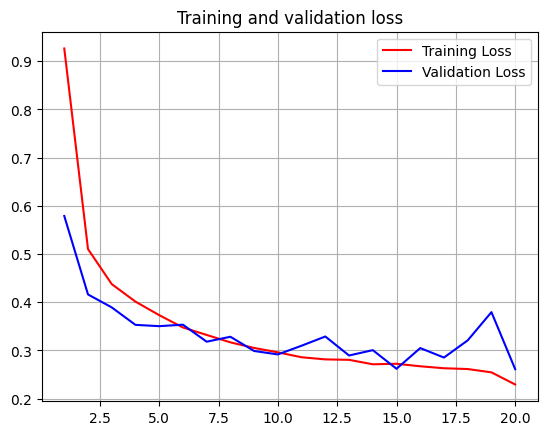

In [16]:
# Plot the learning curves
plot_learning_curves(train_accuracies, val_accuracies, train_losses, val_losses)

In [18]:
# load test data
pytorch_test_dataset = TFDatasetAdapter(test_ds, fixed_length, n_mfcc, n_fft, hop_length, n_mels, augmentations=None)
test_loader = DataLoader(pytorch_test_dataset, batch_size=batch_size, shuffle=False,num_workers=4,prefetch_factor=2)

# Evaluate the model on the test set
accuracy = 0
total = 0
model.eval()

with torch.no_grad():
    for audio, labels in test_loader:
        audio, labels = audio.to("cuda"), labels.to("cuda")
        outputs = model(audio)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        accuracy += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * accuracy / total}%')


Test Accuracy: 85.8282208588957%
